## Analysis

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

from astropy.time import Time

from scipy.stats import binned_statistic_2d

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("/epyc/projects/thor/thor")

In [2]:
import thor

### Simulations

In [3]:
RUN_DIR = "/epyc/projects/thor/results/msst_4x4/run_16/"
DATABASE = "/epyc/projects/thor/data/msst_4x4/msst_survey.db"
con = sql.connect(DATABASE)

In [4]:
allObjects_survey = pd.read_csv(os.path.join(RUN_DIR, "allObjects_survey.txt"), sep=" ", index_col=False)
summary_survey = pd.read_csv(os.path.join(RUN_DIR, "summary_survey.txt"), sep=" ", index_col=False)
summary_orbits = pd.read_csv(os.path.join(RUN_DIR, "summary_orbits.txt"), sep=" ", index_col=False)
test_orbits_survey = pd.read_csv(os.path.join(RUN_DIR, "orbits.txt"), sep=" ", index_col=False)

known_orbits = pd.read_sql("SELECT * FROM mpcOrbitCat", con)
known_orbits = known_orbits[known_orbits["designation"].isin(allObjects_survey["designation"].values)]

In [5]:
observations = pd.read_sql("""SELECT * FROM observations""", con)

In [122]:
projected_obs = pd.read_csv("/epyc/projects/thor/results/msst_4x4/run_16/orbit_0006/projected_obs.txt", index_col=False, sep=" ")
clusterMembers = pd.read_csv("/epyc/projects/thor/results/msst_4x4/run_16/orbit_0006/clusterMembers.txt", index_col=False, sep=" ")
allClusters = pd.read_csv("/epyc/projects/thor/results/msst_4x4/run_16/orbit_0006/allClusters.txt", index_col=False, sep=" ")

In [166]:
known_orbits[known_orbits["designation"].isin(["K03SQ2J"])]

,designation,H,G,epoch_pf_TT,meanAnom_deg,argPeri_deg,ascNode_deg,i_deg,e,n_deg_p_day,...,numObs,numOppos,obsArc,rmsResid_arcsec,coarsePerturbers,precisePerturbers,compName,flags,readableDesignation,lastObsInOrbitSolution
653545,K03SQ2J,17.6,0.15,K03A8,0.13314,6.45775,18.57656,33.66076,0.164757,0.23502,...,19.0,1.0,27 days,0.51,None,None,MPCW,2000,2003 SJ262,20031024.0


In [124]:
obs_ids = clusterMembers[clusterMembers["cluster_id"] == 14]["obsId"].values

In [125]:
from astropy import constants as c
from astropy import units as u

from scipy import roots

In [126]:
MU = (c.G * c.M_sun).to(u.AU**3 / u.day**2).value

In [165]:
t = projected_obs[projected_obs["obsId"].isin(obs_ids[[0, 3, -1]])]["mjd_utc"].values
coords_eq_ang = np.radians(projected_obs[projected_obs["obsId"].isin(obs_ids[[0, 3, -1]])][["RA_deg", "Dec_deg"]].values)
observer_coords =  projected_obs[projected_obs["obsId"].isin(obs_ids[[0, 3, -1]])][['HEclObsy_X_au', 'HEclObsy_Y_au', 'HEclObsy_Z_au']].values
r_truth = projected_obs[projected_obs["obsId"].isin(obs_ids[[0, 3, -1]])][['r_au']].values
obj_truth = projected_obs[projected_obs["obsId"].isin(obs_ids[[0, 3, -1]])][['HEclObj_X_au', 'HEclObj_Y_au', 'HEclObj_Z_au']].values
projected_obs[projected_obs["obsId"].isin(obs_ids[[0, 3, -1]])]

,obsId,visitId,fieldId,fieldRA_deg,fieldDec_deg,exp_mjd,night,designation,code,mjd_utc,...,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,EccAnom,TrueAnom,PosAngle_deg,theta_x_deg,theta_y_deg,theta_x_eq_deg,theta_y_eq_deg
21452,145298,446,446,176.282918,4.230249,59740.246528,59740,K03SQ2J,I11,59740.246528,...,-0.192653,-0.996779,0.000045,165.405104,167.621918,158.850399,7.515453,0.427467,7.186698,-2.440555
127562,1124714,4046,446,176.282918,4.230249,59746.246528,59746,K03SQ2J,I11,59746.246528,...,-0.092206,-1.011646,0.000048,166.620861,168.655779,151.608980,7.376779,-0.176527,6.607055,-2.913824
236671,2130591,7646,446,176.282918,4.230249,59752.246528,59752,K03SQ2J,I11,59752.246528,...,0.009195,-1.016292,0.000047,167.835772,169.688199,145.930357,7.241163,-0.777085,6.067290,-3.360467


In [128]:
from thor.coordinates import equatorialToEclipticCartesian
from thor.coordinates import equatorialAngularToCartesian

In [134]:
observer_coords

array([[-1.92653375e-01, -9.96779136e-01,  4.45859000e-05],
       [-9.22061720e-02, -1.01164631e+00,  4.82342000e-05],
       [ 9.19492130e-03, -1.01629173e+00,  4.70562000e-05]])

array([[-0.19265338, -0.99677914],
       [-0.09220617, -1.01164631],
       [ 0.00919492, -1.01629173]])

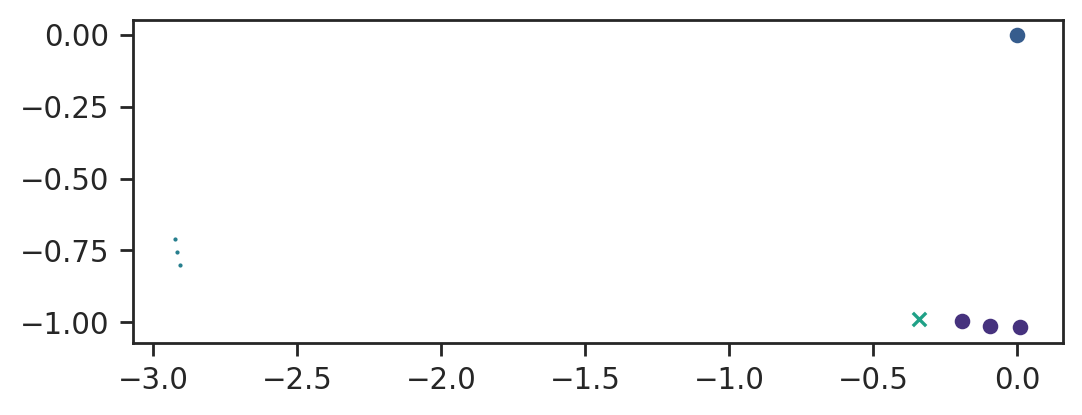

In [250]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*observer_coords[:,:2].T)
ax.scatter(0,0)
ax.set_aspect("equal")
ax.scatter(*obj_truth[:, :2].T, s=0.5)
ax.scatter(*elements_cart[:2], marker="x")

In [244]:
C = c.c.to(u.au / u.d).value

def _calcV(rho1hat, rho2hat, rho3hat):
    # Vector triple product that gives the area of 
    # the "volume of the parallelepiped" or according to 
    # to Milani et al. 2008: 3x volume of the pyramid with vertices q, r1, r2, r3.
    # Note that vector triple product rules apply here.
    return np.dot(np.cross(rho1hat, rho2hat), rho3hat)

def _calcA(q1, q2, q3, rho1hat, rho3hat, t31, t32, t21):
    return np.dot(np.cross(np.linalg.norm(q2)**3 * rho1hat, rho3hat), (t32 * q1 - t31 * q2 + t21 * q3))

def _calcB(q1, q3, rho1hat, rho3hat, t31, t32, t21):
    return np.dot(np.cross(MU / 6 * t32 * t21 * rho1hat, rho3hat), ((t31 + t32) * q1 + (t31 + t21) * q3))

def _calcLambdas(r2_mag, t31, t32, t21):
    lambda1 = t32 / t31 * (1 + MU / (6 * r2_mag**3) * (t31**2 - t32**2))
    lambda3 = t21 / t31 * (1 + MU / (6 * r2_mag**3) * (t31**2 - t21**2))
    return lambda1, lambda3

def _calcRhos(lambda1, lambda3, q1, q2, q3, rho1hat, rho2hat, rho3hat, V):
    # This can be derived by taking a series of scalar products of the coplanarity condition equation
    # with cross products of unit vectors in the direction of the observer
    numerator = -lambda1 * q1 + q2 - lambda3 * q3
    rho1_mag = np.dot(numerator, np.cross(rho2hat, rho3hat)) / (lambda1 * V)
    rho2_mag = np.dot(numerator, np.cross(rho1hat, rho3hat)) / V
    rho3_mag = np.dot(numerator, np.cross(rho1hat, rho2hat)) / (lambda3 * V)
    return np.dot(rho1_mag, rho1hat), np.dot(rho2_mag, rho2hat), np.dot(rho2_mag, rho2hat)


def calcHerrickGibbs(r1, r2, r3, t31, t32, t21):
    # Following formula in Vallado Page 466
    v2 = (-t32 * (1 / (t21 * t31) + MU / (12 * np.linalg.norm(r1)**3)) * r1 
          + (t32 - t21) * (1 / (t21 * t32) + MU / (12 * np.linalg.norm(r2)**3)) * r2
          + t21 * (1 / (t32 * t31) + MU / (12 * np.linalg.norm(r3)**3)) * r3)
    return v2

def calcGibbs(r1, r2, r3):
    
    r1_mag = np.linalg.norm(r1)
    r2_mag = np.linalg.norm(r2)
    r3_mag = np.linalg.norm(r3)
    Z12 = np.cross(r1, r2)
    Z23 = np.cross(r2, r3)
    Z31 = np.cross(r3, r1)
    
    N = r1_mag * Z23 + r2_mag * Z31 * r3_mag * Z12
    N_mag = np.linalg.norm(N)
    D = Z12 + Z23 + Z31
    D_mag = np.linalg.norm(D)
    S = (r2_mag - r3_mag) * r1 + (r3_mag - r1_mag) * r2 + (r1_mag - r2_mag) * r3
    S_mag = np.linalg.norm(S)
    B = np.cross(D, r2)
    Lg = np.sqrt(MU / N_mag / D_mag)
    v2 = Lg / r2_mag * B + Lg * S
    
    print(S_mag/D_mag)
    return v2
    

def iod(coords_eq_ang, t):
    rho = equatorialToEclipticCartesian(equatorialAngularToCartesian(coords_eq_ang))
    rho1 = rho[0]
    rho2 = rho[1]
    rho3 = rho[2]
    q1 = observer_coords[0]
    q2 = observer_coords[1]
    q3 = observer_coords[2]
    q2_mag = np.linalg.norm(q2)

    rho1hat = rho1 / np.linalg.norm(rho1)
    rho2hat = rho2 / np.linalg.norm(rho2)
    rho3hat = rho3 / np.linalg.norm(rho3)

    t31 = t[2] - t[0]
    t21 = t[1] - t[0]
    t32 = t[2] - t[1]
    
    
    A = _calcA(q1, q2, q3, rho1hat, rho3hat, t31, t32, t21)
    B = _calcB(q1, q3, rho1hat, rho3hat, t31, t32, t21)
    V = _calcV(rho1hat, rho2hat, rho3hat)
    coseps2 = np.dot(q2 / np.linalg.norm(q2), rho2hat) 
    C0 = V * t31 * q2_mag**4 / B
    h0 = - A / B

    # Find roots to eighth order polynomial
    all_roots = roots([
        C0**2,
        0,
        -q2_mag**2 * (h0**2 + 2 * C0 * h0 * coseps2 + C0**2),
        0,
        0,
        2 * q2_mag**5 * (h0 + C0 * coseps2),
        0,
        0,
        -q2_mag**8
    ])
    
    # Keep only positive real roots (which should at most be 3)
    r2_mags = np.real(all_roots[np.isreal(all_roots) & (np.real(all_roots) >= 0)])
    num_solutions = len(r2_mags)
    
    orbits = []
    for r2_mag in r2_mags:
        lambda1, lambda3 = _calcLambdas(r2_mag, t31, t32, t21)
        rho1, rho2, rho3 = _calcRhos(lambda1, lambda3, q1, q2, q3, rho1hat, rho2hat, rho3hat, V)

        # Test if we get the same rho2 as using equation 22 in Milani et al. 2008
        rho2_mag = (h0 - q2_mag**3 / r2_mag**3) * q2_mag / C0
        np.testing.assert_almost_equal(np.dot(rho2_mag, rho2hat), rho2)

        r1 = q1 + rho1
        r2 = q2 + rho2
        r3 = q3 + rho3

        # Calculate v2 using Herrick-Gibbs
        v2 = calcGibbs(r1, r2, r3)# t31, t32, t21)
        orbit = np.concatenate([r2, v2])
        
        if np.linalg.norm(v2) >= C:
            print("Velocity is greater than speed of light!")
        orbits.append(orbit)
    
    return np.array(orbits)

In [245]:
orbits = iod(coords_eq_ang, t)

0.9755678493430143
0.40640115593823994
0.011438863661530513


In [255]:
orbits[0].shape

(6,)

In [266]:
elements_cart = orbits[1]

In [267]:
elements_cart

array([-3.41285297e-01, -9.89010917e-01,  1.26087761e-02,  1.29897772e-03,
       -1.55914819e-04, -1.87609246e-05])

In [268]:
r = elements_cart[:3]
v = elements_cart[3:]
v_mag = np.linalg.norm(v)
r_mag = np.linalg.norm(r)

sme = v_mag**2 / 2 - MU / r_mag
a = -2 * sme / MU

h = np.cross(r, v)
h_mag = np.linalg.norm(h)

n = np.cross(np.array([0, 0, 1]), h)
n_mag = np.linalg.norm(n)

e = ((v_mag**2 - MU / r_mag) * r - (np.dot(r, v)) * v) / MU
e_mag = np.linalg.norm(e)

i = np.degrees(np.arccos(h[2] / h_mag))

ascNode = np.degrees(np.arccos(n[0] / n_mag))
if n[1] < 0:
    ascNode = 360.0 - ascNode

argPeri = np.degrees(np.arccos(np.dot(n, e) / (n_mag * e_mag)))
if e[2] < 0:
    argPeri = 360.0 - argPeri
    
trueAnom = np.degrees(np.arccos(np.dot(e, r) / (e_mag * r_mag)))
if np.dot(r, v) < 0:
    trueAnom = 360.0 - trueAnom


In [269]:
known_orbits[known_orbits["designation"] == "K03SQ2J"]

,designation,H,G,epoch_pf_TT,meanAnom_deg,argPeri_deg,ascNode_deg,i_deg,e,n_deg_p_day,...,numObs,numOppos,obsArc,rmsResid_arcsec,coarsePerturbers,precisePerturbers,compName,flags,readableDesignation,lastObsInOrbitSolution
653545,K03SQ2J,17.6,0.15,K03A8,0.13314,6.45775,18.57656,33.66076,0.164757,0.23502,...,19.0,1.0,27 days,0.51,None,None,MPCW,2000,2003 SJ262,20031024.0


In [271]:
e_mag

0.9942177316776171

In [261]:
r_truth

array([[3.0151848 ],
       [3.01738251],
       [3.01939124]])

In [ ]:
mask = ((np.absolute(projected_obs["theta_x_deg"]) < 0.25) 
        & (np.absolute(projected_obs["theta_y_deg"]) < 0.25) 
        & (~projected_obs["designation"].isin(["NS"])))
objs = ["F3455", "K10T54J"]

In [ ]:
fig = plotProjections(projected_obs[projected_obs["designation"].isin(objs)], colorByObject=True)

In [ ]:
rangeAndShift?

In [ ]:
projected_obs[projected_obs["designation"].isin(objs)].columns

In [ ]:
orbit_col = ['HEclObj_X_au', 'HEclObj_Y_au', 'HEclObj_Z_au',
             'HEclObj_dX/dt_au_p_day', 'HEclObj_dY/dt_au_p_day',
             'HEclObj_dZ/dt_au_p_day']

In [ ]:
mjds = projected_obs[projected_obs["designation"].isin([objs[0]])]["mjd_utc"].values
target = projected_obs[projected_obs["designation"].isin([objs[0]])][orbit_col].values
target_theta = projected_obs[projected_obs["designation"].isin([objs[0]])][["theta_x_deg", "theta_y_deg"]].values
initial = projected_obs[projected_obs["designation"].isin([objs[-1]])][orbit_col].values

In [ ]:
target_theta

In [ ]:
from thor import propagateTestParticle
from thor import rangeAndShift

In [ ]:
delta  = initial * 0.01

In [ ]:
mod = initial + delta

In [ ]:
mjds

In [ ]:
propagateTestParticle(mod[0], mjds[0], [mjds[1]])

In [ ]:
findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values
found = allObjects_survey[allObjects_survey["found"] == 1]["designation"].values
missed = allObjects_survey[(allObjects_survey["found"] == 0) & (allObjects_survey["findable"] == 1) ]["designation"].values
test_orbits = test_orbits_survey["designation"].values

falsePositiveIDs = ["NS"]
unknownIDs = []

In [ ]:
observations